In [1]:
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import pandas_ta
import seaborn as sns
import yfinance as yf

In [2]:
data = yf.download(tickers="KOZAA.IS", period="max", interval="5m", start="2021-07-20")
data.drop(["Close"], axis=1, inplace=True)
data.rename(columns={"Adj Close": "Close"}, inplace=True)
data.index.name = "Date"
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2021-07-26 09:55:00+03:00,13.390000,13.390000,13.390000,13.390000,0
2021-07-26 10:00:00+03:00,13.390000,13.450000,13.380000,13.430000,188456
2021-07-26 10:05:00+03:00,13.430000,13.440000,13.390000,13.400000,164166
2021-07-26 10:10:00+03:00,13.400000,13.400000,13.370000,13.390000,103148
2021-07-26 10:15:00+03:00,13.380000,13.410000,13.370000,13.390000,154397
...,...,...,...,...,...
2021-09-03 17:05:00+03:00,16.270000,16.340000,16.260000,16.309999,251527
2021-09-03 17:10:00+03:00,16.309999,16.320000,16.240000,16.250000,238330
2021-09-03 17:15:00+03:00,16.260000,16.260000,16.209999,16.219999,113516


In [3]:
# Moving Average based signals
data["SMA8"] = data.ta.sma(8)
data["SMA13"] = data.ta.sma(13)
data.dropna(inplace=True)
data["Position"] = np.where(data["SMA8"] > data["SMA13"], 1, -1)

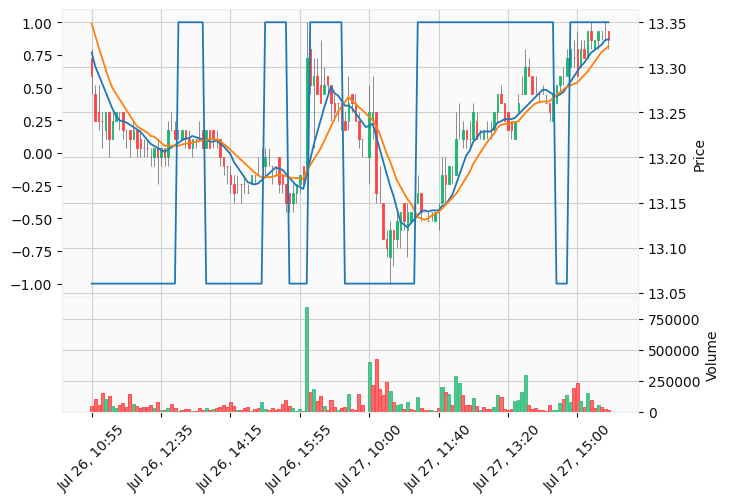

In [4]:
n = 150

apds = [
    mpf.make_addplot(data["SMA8"][:n]),
    mpf.make_addplot(data["SMA13"][:n]),
    mpf.make_addplot(data["Position"][:n], secondary_y=True),
]

mpf.plot(data.iloc[:n], volume=True, type="candle", addplot=apds, style="yahoo")

C:\Users\murat\AppData\Roaming\Python\Python39\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Date'>

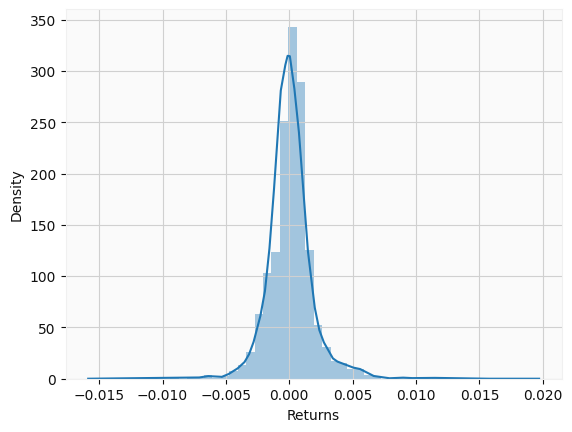

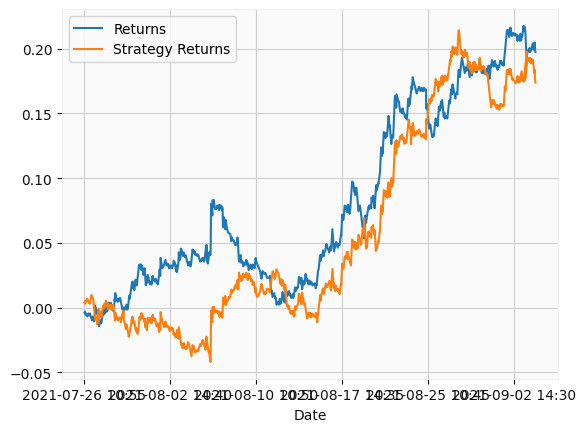

In [5]:
# Signal Performance

# Stock returns and position returns
data["Returns"] = np.log(data["Close"] / data["Close"].shift(1))
data["Strategy_returns"] = data["Position"].shift(1) * data["Returns"]

sns.distplot(data["Returns"])

pd.DataFrame(
    {
        "Returns": data["Returns"].values,
        "Strategy Returns": data["Strategy_returns"].values,
    },
    index=data.index.strftime("%Y-%m-%d %H:%M"),
).cumsum().plot()

In [6]:
# Performance statistics
# Annualized risk-return
annualized_return = np.exp(data[["Returns", "Strategy_returns"]].mean() * 252) - 1
annualized_risk = (
    data[["Returns", "Strategy_returns"]].apply(np.exp) - 1
).std() * 252 ** 0.5

print(f"Annualized return:\n {annualized_return}")
print(f"Annualized risk:\n {annualized_risk}")

# Maximum drawdown and longest drawdown period
data["cumret"] = data["Strategy_returns"].cumsum().apply(np.exp)
data["cummax"] = data["cumret"].cummax()
drawdown = data["cummax"] - data["cumret"]

max_drawdown = drawdown.max()

periods = (
    drawdown[drawdown == 0][1:].index.to_pydatetime()
    - drawdown[drawdown == 0][:-1].index.to_pydatetime()
)

longest_period = periods.max()

print(f"Maximum drawdown:\n {max_drawdown}")
print(f"Longest period:\n {longest_period}")

Annualized return:
 Returns             0.019122
Strategy_returns    0.016821
dtype: float64
Annualized risk:
 Returns             0.029143
Strategy_returns    0.029155
dtype: float64
Maximum drawdown:
 0.07372274047757821
Longest period:
 10 days, 22:50:00


In [7]:
# Mean Reversion based signals

# Drop previous results
# We'll use SMA(8) and Returns for Mean reversion so I'll not drop it
data.drop(
    ["SMA13", "Position", "Strategy_returns", "cumret", "cummax"], axis=1, inplace=True
)

In [8]:
data["Distance"] = data["Close"] - data["SMA8"]

threshold = np.std(data.Distance) * 1.5  # Threshold for signal generation

data["Position"] = np.where(data["Distance"] > threshold, -1, np.nan)
data["Position"] = np.where(data["Distance"] < -threshold, 1, data["Position"])
data["Position"] = np.where(
    data["Distance"] * data["Distance"].shift(1) < 0, 0, data["Position"]
)
data["Position"] = data["Position"].ffill().fillna(0)

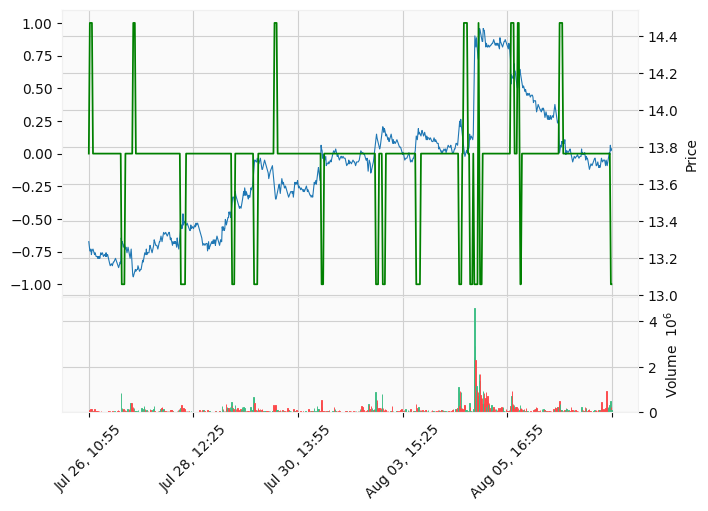

In [9]:
n = 1000

apds = [mpf.make_addplot(data["Position"][:n], color="g", secondary_y=True)]

mpf.plot(data.iloc[:n], volume=True, type="line", addplot=apds, style="yahoo")

<AxesSubplot:xlabel='Date'>

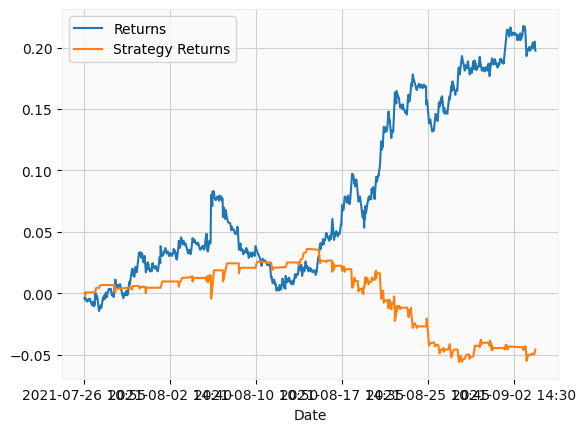

In [10]:
data["Strategy_returns"] = data["Position"].shift(1) * data["Returns"]

pd.DataFrame(
    {
        "Returns": data["Returns"].values,
        "Strategy Returns": data["Strategy_returns"].values,
    },
    index=data.index.strftime("%Y-%m-%d %H:%M"),
).cumsum().plot()

In [11]:
# Performance statistics
# Annualized risk-return
annualized_return = np.exp(data[["Returns", "Strategy_returns"]].mean() * 252) - 1
annualized_risk = (
    data[["Returns", "Strategy_returns"]].apply(np.exp) - 1
).std() * 252 ** 0.5

print(f"Annualized return:\n {annualized_return}")
print(f"Annualized risk:\n {annualized_risk}")

# Maximum drawdown and longest drawdown period
data["cumret"] = data["Strategy_returns"].cumsum().apply(np.exp)
data["cummax"] = data["cumret"].cummax()
drawdown = data["cummax"] - data["cumret"]

max_drawdown = drawdown.max()

periods = (
    drawdown[drawdown == 0][1:].index.to_pydatetime()
    - drawdown[drawdown == 0][:-1].index.to_pydatetime()
)

longest_period = periods.max()

print(f"Maximum drawdown:\n {max_drawdown}")
print(f"Longest period:\n {longest_period}")

Annualized return:
 Returns             0.019122
Strategy_returns   -0.004377
dtype: float64
Annualized risk:
 Returns             0.029143
Strategy_returns    0.016767
dtype: float64
Maximum drawdown:
 0.09111002302393967
Longest period:
 4 days, 23:40:00
